# Daily Average Glucose

This notebook generates daily average glucose chart from blood glucose readings held in the Health Tracker database and retrieved via the Health Tracker Web Service:

- A line plot for daily mean
- +/- 1 standard deviation shaded area, indicating daily variability
- Target zone indicator

Both charts include the median line.

Before attempting to run the notebook:

- Make sure the variables defined in "config.ipynb" are set correctly
- Set the reporting date range and export options in the first code cell

In [15]:
from datetime import date, timedelta

# Reporting date range
start = date(2025, 4, 17)
end = start + timedelta(days=11)

# Whether to export the data to a spreadsheet
export_spreadsheet = True

# Export format for the chart:
# PNG     - export as PNG image
# PDF     - export as PDF file
# <blank> - do not export
chart_export_format = "PNG"

In [16]:
# Set the Y-axis limits
y_min = 3
y_max = 15

In [17]:
%run ../api.ipynb
%run ../config.ipynb
%run ../export.ipynb

In [18]:
# Log in to the service, get the person ID and retrieve the data
token = authenticate(url, username, password)
person_id = get_person_id(url, token, firstnames, surname)
df = get_blood_glucose_measurements(url, token, person_id, start, end)

# Preview the data
df.head()

,level,id,personId,date
0,6.4,5561,1,2025-04-17 18:52:57
1,7.1,5562,1,2025-04-17 18:57:57
2,7.7,5563,1,2025-04-17 19:02:57
3,8.3,5564,1,2025-04-17 19:07:57
4,8.5,5565,1,2025-04-17 19:12:56


In [19]:
# Rename the date column to timestamp and generate a date-only column
df.rename(columns={ "date": "timestamp" }, inplace=True)
df["date"] = df["timestamp"].dt.date

# Group by date and calculate mean and standard deviation
daily_stats = df.groupby("date")["level"].agg(["mean", "std"]).reset_index()

# Preview the data
daily_stats.head()

,date,mean,std
0,2025-04-17,8.132258,0.905317
1,2025-04-18,7.713889,1.240328
2,2025-04-19,7.703125,1.142872
3,2025-04-20,8.370139,0.985935
4,2025-04-21,7.765625,0.789102


In [20]:
# Export the data to a spreadsheet
if export_spreadsheet:
    export_to_spreadsheet("glucose_daily_mean", { "Daily Mean": daily_stats })

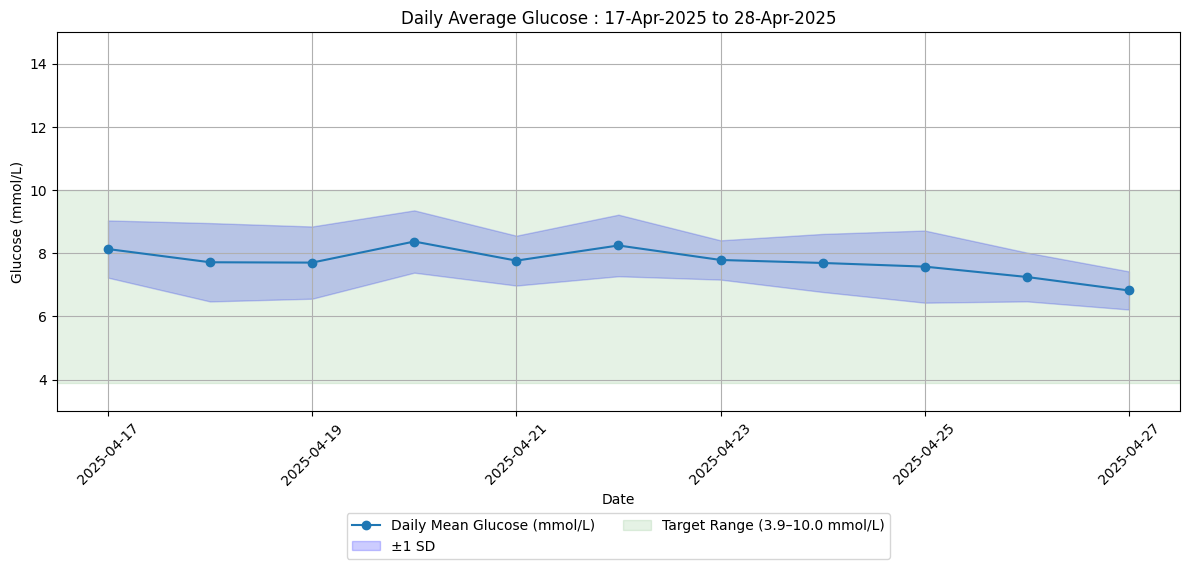

In [21]:
import matplotlib.pyplot as plt

# Plot setup
plt.figure(figsize=(12, 6))

# Plot daily mean glucose
plt.plot(daily_stats["date"], daily_stats["mean"], label="Daily Mean Glucose (mmol/L)", marker="o")

# Plot ±1 standard deviation as a shaded area
plt.fill_between(
    daily_stats["date"],
    daily_stats["mean"] - daily_stats["std"],
    daily_stats["mean"] + daily_stats["std"],
    color="blue",
    alpha=0.2,
    label="±1 SD"
)

# Add target range band: 3.9–10.0 mmol/L
plt.axhspan(3.9, 10.0, color="green", alpha=0.1, label="Target Range (3.9–10.0 mmol/L)")

# Formatting
plt.title(f"Daily Average Glucose : {start.strftime('%d-%b-%Y')} to {end.strftime('%d-%b-%Y')}")
plt.xlabel("Date")
plt.ylabel("Glucose (mmol/L)")
plt.ylim(y_min, y_max)
plt.xticks(rotation=45)
plt.grid(True)

# Legend below chart
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()

# Export to PNG or PDF, if required
export_chart("glucose_daily_mean", None, chart_export_format)

# Show the plot
plt.show()
